### Importing Libraries and Device Configuration

#### **1. Library Imports**
This project uses the following libraries:
- **`io`**: For file handling and working with text data.
- **`unicodedata` and `string`**: To preprocess text data by normalizing Unicode characters and handling strings.
- **`random` and `re`**: For random operations and regex-based text processing.
- **PyTorch**:
  - **`torch`**: Core library for deep learning.
  - **`torch.nn`**: For defining neural network layers and architectures.
  - **`torch.utils.data`**: For handling datasets and creating data loaders.
- **`numpy`**: For numerical operations on arrays and tensors.
- **`matplotlib.pyplot`**: To visualize results and metrics.
- **`sklearn.metrics`**: To calculate evaluation metrics like accuracy, precision, and recall.

#### **2. Device Configuration**
- **`device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`**:
  - Sets the computation device to **GPU** if available for faster processing, otherwise defaults to **CPU**.



In [ ]:
from io import open
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloading and Preparing the Dataset

#### **Code Explanation**
1. **Remove Existing Files**:
   - **`!rm spa-eng.zip _about.txt spa.txt`**:
     - Deletes any previously downloaded or extracted files to ensure a clean setup.

2. **Download the Dataset**:
   - **`!wget https://www.manythings.org/anki/spa-eng.zip`**:
     - Downloads a zipped text file containing English-to-Spanish phrase translations from the [Tatoeba Project](https://tatoeba.org/).

3. **Unzip the File**:
   - **`!unzip spa-eng.zip`**:
     - Extracts the downloaded zip file to obtain the `spa.txt` file, which contains the translations.

4. **List Extracted Files**:
   - **`!ls`**:
     - Displays the files in the current directory to confirm successful extraction.



In [ ]:
# Here we download and unzip the text file that contains all of our translated phrases
!rm spa-eng.zip _about.txt spa.txt
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls

--2024-11-13 23:03:36--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.17M  2.97MB/s    in 1.7s    

2024-11-13 23:03:38 (2.97 MB/s) - ‘spa-eng.zip’ saved [5420295/5420295]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
_about.txt  sample_data  spa-eng.zip  spa.txt


### Preprocessing Text Data

#### **1. `unicodeToAscii(s)`**
- **Purpose**: Converts a Unicode string into ASCII by normalizing characters.
- **How It Works**:
  - Uses `unicodedata.normalize('NFD', s)` to decompose Unicode characters into base characters and diacritics.
  - Filters out diacritics (`Mn` category), leaving only base characters.


In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    pairs = [[pair[0], pair[1]] for pair in pairs]
    return pairs

### Splitting Data into Training, Validation, and Test Sets

#### **1. Parse Data**
- **`pairs = parse_data("spa.txt")`**:
  - Reads and preprocesses the `spa.txt` file using the `parse_data` function.
  - Converts the dataset into a list of normalized English-Spanish sentence pairs.

#### **2. Extract English Sentences**
- **`english_sentences = [pair[0] for pair in pairs]`**:
  - Extracts all English sentences from the parsed data.
  - Each sentence corresponds to the first element in each sentence pair.

#### **3. Shuffle the Data**
- **`random.shuffle(english_sentences)`**:
  - Randomizes the order of English sentences to ensure the dataset is not biased by its original order.

#### **4. Data Splitting**
- Divides the shuffled English sentences into:
  - **Training Set**: First 1,000 sentences (`train_sentences`).
  - **Validation Set**: Next 1,000 sentences (`val_sentences`).
  - **Test Set**: Following 1,000 sentences (`test_sentences`).
- **Purpose**:
  - Training set: Used to train the model.
  - Validation set: Used to tune hyperparameters and evaluate during training.
  - Test set: Used to evaluate the model's performance on unseen data.



In [ ]:
pairs = parse_data("spa.txt")
english_sentences = [pair[0] for pair in pairs]
random.shuffle(english_sentences)
print("Number of English sentences:", len(english_sentences))

train_sentences = english_sentences[:1000]
val_sentences = english_sentences[1000:2000]
test_sentences = english_sentences[2000:3000]

Number of English sentences: 141543


### Creating a Dictionary for One-Hot Encoding

#### **Function: `add_words_to_dict`**
This function creates a dictionary of unique words from a list of sentences and assigns each word a unique index for use in one-hot encoding.

#### **Parameters**
1. **`word_dictionary`**: A dictionary where each word is mapped to a unique index.
2. **`word_list`**: A list that keeps track of all unique words in the same order as the dictionary.
3. **`sentences`**: A list of sentences from which words are extracted.

#### **How It Works**
1. Iterates over each sentence in the `sentences` list.
2. Splits each sentence into individual words using `.split(" ")`.
3. Checks if a word is already in the dictionary:
   - **If the word is not in the dictionary**:
     - Adds the word to `word_list`.
     - Assigns it an index in the dictionary based on its position in the `word_list`.


In [ ]:
# Using this function we will create a dictionary to use for our one hot encoding vectors
def add_words_to_dict(word_dictionary, word_list, sentences):
    for sentence in sentences:
        for word in sentence.split(" "):
            if word in word_dictionary:
                continue
            else:
                word_list.append(word)
                word_dictionary[word] = len(word_list)-1

english_dictionary = {}
english_list = []
add_words_to_dict(english_dictionary, english_list, train_sentences)
add_words_to_dict(english_dictionary, english_list, val_sentences)
add_words_to_dict(english_dictionary, english_list, test_sentences)

### Creating Input and Target Tensors for Sequence Modeling

#### **1. Function: `create_input_tensor`**
- **Purpose**: Converts a sentence into a one-hot encoded tensor for input to the model.
- **Steps**:
  1. Splits the sentence into words.
  2. Initializes a 3D tensor with dimensions:
     - Length of the sentence (number of words).
     - Batch size (1 for simplicity).
     - Vocabulary size (`len(word_dictionary) + 1`).
  3. For each word:
     - Checks if it exists in the dictionary.
     - Sets the corresponding index to `1` in the one-hot encoding.

#### 2. **Function: `create_target_tensor`**
- **Purpose**: Converts a sentence into a one-hot encoded tensor for the target sequence.
- **Steps**:
Similar to `create_input_tensor`, but with an offset:
- Maps each word in the sentence to the next word in the sequence.
- Adds an End of Sequence (EOS) token at the end of the tensor to signify the end of the target sequence.

#### 3. **Creating Dataset Tensors**
- Creates input and target tensor pairs for each sentence in the training set.
- Validation and Test Tensors: Similar process is used for validation (val_tensors) and test (test_tensors) datasets.

In [ ]:
def create_input_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary) + 1)
    for idx, word in enumerate(words):
        if word in word_dictionary:
            tensor[idx][0][word_dictionary[word]] = 1
    return tensor

def create_target_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary) + 1)
    for idx in range(1, len(words)):
        word = words[idx]
        if word in word_dictionary:
            tensor[idx - 1][0][word_dictionary[word]] = 1
    tensor[len(words) - 1][0][len(word_dictionary)] = 1 # EOS
    return tensor

train_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in train_sentences]
val_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in val_sentences]
test_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in test_sentences]

### Organizing Data for Model Training and Evaluation

#### **Creating Dataloaders**
- **`dataloaders`**:
  - A dictionary that organizes the preprocessed dataset tensors into training, validation, and test sets.
  - Each key (`'train'`, `'val'`, `'test'`) corresponds to a list of tuples where:
    - The first element of each tuple is an input tensor.
    - The second element is the corresponding target tensor.

#### **Calculating Dataset Sizes**
- **`dataset_sizes`**:
  - A dictionary that stores the size (number of samples) for each phase of the dataset (`'train'`, `'val'`, `'test'`).
    - Iterates over the `dataloaders` dictionary and calculates the length of each dataset phase.


In [ ]:
dataloaders = {'train': train_tensors, 'val': val_tensors, 'test': test_tensors}
dataset_sizes = {phase: len(dataloaders[phase]) for phase in dataloaders}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}


### Defining the LSTM Model for Sequence Prediction

#### **Class: `LSTM`**
This class implements a Long Short-Term Memory (LSTM) neural network for sequence modeling, designed to handle sequential data like text or time series.

#### **Key Components**
1. **Initialization (`__init__`)**:
   - **`input_size`**: Size of the input features (number of unique words in the vocabulary).
   - **`hidden_size`**: Number of features in the hidden state of the LSTM.
   - **`output_size`**: Number of output features (e.g., vocabulary size for sequence prediction).
   - **`dropout`**: Dropout probability to reduce overfitting (default: 0.3).
   - **Layers**:
     - **`nn.LSTM`**:
       - Two-layer LSTM with dropout between layers.
       - Processes sequential input data and captures temporal dependencies.
     - **`nn.Linear`**:
       - Fully connected layer that maps the LSTM's hidden state to the output space (e.g., vocabulary).
     - **`nn.Dropout`**:
       - Adds regularization to prevent overfitting, applied before the fully connected layer.

2. **Forward Pass (`forward`)**:
   - **Input**:
     - `input`: Input tensor representing the sequence.
     - `hidden`: Hidden state from the previous timestep.
   - **Steps**:
     1. Passes the input and hidden state through the LSTM layer.
     2. Applies dropout to the last output of the LSTM (`output[-1]`).
     3. Passes the result through the fully connected layer for final predictions.
   - **Output**:
     - `output`: Predicted values for the next word in the sequence.
     - `hidden`: Updated hidden state for the next timestep.

3. **Initialize Hidden State (`initHidden`)**:
   - Creates initial hidden and cell states filled with zeros.
   - Dimensions:
     - Number of layers: `2` (since the LSTM has two layers).
     - Batch size: Number of sequences in the batch.
     - Hidden size: Number of features in the LSTM's hidden state.


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        # Add dropout to the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, dropout=dropout)  # Dropout between layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)  # Dropout before the fully connected layer

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        output = self.dropout(output[-1])  # Apply dropout before the fully connected layer
        output = self.fc(output)
        return output, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size).to(device),
                torch.zeros(2, batch_size, self.hidden_size).to(device))

### Initializing the LSTM Model

#### **Model Parameters**
1. **`input_size`**:
   - Calculated as `len(english_dictionary) + 1`.
   - Represents the size of the vocabulary plus one additional index for the End-of-Sequence (EOS) token.

2. **`hidden_size`**:
   - Set to `128`.
   - Defines the number of features in the hidden state of the LSTM.
   - A higher hidden size enables the model to capture more complex patterns.

3. **`output_size`**:
   - Same as `input_size` (`len(english_dictionary) + 1`).
   - Matches the vocabulary size plus EOS for predicting the next word in the sequence.

#### **Model Initialization**
- **`lstm_model = LSTM(input_size, hidden_size, output_size).to(device)`**:
  - Creates an instance of the `LSTM` model with the specified input size, hidden size, and output size.
  - Moves the model to the computation device (`GPU` if available, otherwise `CPU`).

#### **Purpose**
- The initialized `lstm_model` is ready to process input sequences, predict the next word, and learn temporal dependencies in the data.


In [ ]:
input_size = len(english_dictionary) + 1
hidden_size = 128
output_size = len(english_dictionary) + 1

lstm_model = LSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)

### Hyperparameter Configuration

#### **Learning Rate**
- **`learning_rate = 0.001`**:
  - Determines the step size for updating model weights during training.
  - A moderate value ensures stable convergence without overshooting the optimal solution.

#### **Number of Epochs**
- **`num_epochs = 10`**:
  - Specifies the number of complete passes through the entire training dataset.
  - A balance between training time and model performance.

#### **Weight Decay**
- **`weight_decay = 0.01`**:
  - Implements L2 regularization, which adds a penalty for large weight values.
  - Helps prevent overfitting by encouraging the model to learn simpler patterns.



In [ ]:
learning_rate = 0.001
num_epochs = 10
weight_decay = 0.01  # L2 regularization parameter

### Training the LSTM Model with Early Stopping

#### **Function: `train_lstm`**
This function trains the LSTM model, evaluates it on validation and test datasets, and incorporates early stopping to prevent overfitting.

#### **Parameters**
1. **`model`**: The LSTM model to be trained.
2. **`dataloaders`**: A dictionary containing data loaders for training, validation, and testing datasets.
3. **`dataset_sizes`**: A dictionary specifying the size of each dataset phase (`train`, `val`, `test`).
4. **`criterion`**: The loss function used to calculate errors (e.g., CrossEntropyLoss).
5. **`optimizer`**: The optimization algorithm to update model weights.
6. **`scheduler`**: A learning rate scheduler to adjust the learning rate dynamically.
7. **`num_epochs`**: Number of epochs for training (default: 25).
8. **`patience`**: Number of epochs to wait for improvement before stopping (default: 3).

#### **Key Features**
1. **Training and Evaluation**:
   - Alternates between training and evaluation phases:
     - **Training Phase**:
       - Updates model weights using backpropagation.
     - **Validation and Test Phases**:
       - Evaluates the model without updating weights.

2. **Loss Tracking**:
   - Tracks and stores loss for each phase (`train`, `val`, `test`) over epochs.

3. **Early Stopping**:
   - Monitors validation loss:
     - If no improvement is observed for `patience` epochs, training stops early.

4. **Best Model Weights**:
   - Saves the model weights corresponding to the lowest validation loss.

#### **Workflow**
1. **Epoch Loop**:
   - Iterates over the specified number of epochs (`num_epochs`).
2. **Phase Loop**:
   - For each epoch, processes data in three phases: `train`, `val`, and `test`.
3. **Sequence Handling**:
   - Iterates through each time step of the sequence to compute loss for predictions.



In [ ]:
def train_lstm(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25, patience=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    epochs_no_improve = 0  # Counter for early stopping

    training_curves = {'train_loss': [], 'val_loss': [], 'test_loss': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val', 'test']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0

            for input_sequence, target_sequence in dataloaders[phase]:
                hidden = model.initHidden(batch_size=input_sequence.size(1))

                current_input_sequence = input_sequence.unsqueeze(1).to(device)
                current_target_sequence = target_sequence.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    for i in range(current_input_sequence.size(0)):
                        current_hidden = (hidden[0].to(device), hidden[1].to(device))
                        output, hidden = model(current_input_sequence[i], current_hidden)
                        l = criterion(output, current_target_sequence[i])
                        loss += l

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() / current_input_sequence.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[f'{phase}_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Early stopping check on validation loss
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0  # Reset counter if improvement is seen
                else:
                    epochs_no_improve += 1

        # Check if early stopping is triggered
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)
    return model, training_curves

### Predicting the Next Words in a Sequence

#### **Function: `predict`**
This function generates predictions for the next words in a sequence using the trained LSTM model, simulating text generation or sequence continuation.

#### **Parameters**
1. **`model`**: The trained LSTM model.
2. **`word_dictionary`**: Dictionary mapping words to their unique indices.
3. **`word_list`**: List of words corresponding to indices in the dictionary.
4. **`input_sentence`**: The initial sentence provided for prediction.
5. **`max_length`**: The maximum number of words to generate (default: 20).

#### **How It Works**
1. **Prepare the Input**:
   - Converts the `input_sentence` into a one-hot encoded tensor using `create_input_tensor`.
   - Initializes the hidden state for the model.

2. **Process the Input Sequence**:
   - Feeds the input tensor into the model word by word to process the initial sequence.

3. **Generate Predictions**:
   - Iteratively generates words up to `max_length`:
     - Uses `output.topk(1)` to get the index of the most probable word.
     - Stops if the **End-of-Sequence (EOS)** token is predicted.
     - Appends the predicted word to `output_sentence`.

4. **Update the Input**:
   - Converts the predicted word into a one-hot encoded tensor and feeds it back into the model for the next prediction.

5. **Return**:
   - The final predicted sentence after the loop ends.


In [ ]:
def predict(model, word_dictionary, word_list, input_sentence, max_length=20):
    output_sentence = input_sentence + " "
    tensor = create_input_tensor(input_sentence, word_dictionary)
    hidden = model.initHidden(batch_size=1)
    current_input_sequence = tensor.to(device)

    for i in range(current_input_sequence.size(0)):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        output, hidden = model(current_input_sequence[i], current_hidden)

    for _ in range(max_length):
        topv, topi = output.topk(1)
        topi = topi[0][0].item()

        if topi == len(word_dictionary):
            break

        word = word_list[topi]
        output_sentence += word + " "

        input = create_input_tensor(word, word_dictionary).to(device)
        output, hidden = model(input[0], hidden)

    return output_sentence.strip()

### Training the LSTM Model with Optimizer and Scheduler

#### **1. Loss Function**
- **`criterion = nn.CrossEntropyLoss()`**:
  - Measures the difference between the model's predictions and the actual target values.
  - Suitable for multi-class classification tasks like predicting the next word in a sequence.

#### **2. Optimizer**
- **`optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)`**:
  - Updates the model's weights during training.
  - **Learning rate (`lr=learning_rate`)**: Controls the step size of weight updates.
  - **Weight decay (`weight_decay=0.01`)**: Implements L2 regularization to reduce overfitting.

#### **3. Scheduler**
- **`scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)`**:
  - Gradually reduces the learning rate by multiplying it with `gamma=0.95` after each epoch.
  - Helps the model converge by taking smaller optimization steps as training progresses.

#### **4. Training the Model**
- **`train_lstm`**:
  - Trains the LSTM model using the specified dataloaders, loss function, optimizer, and scheduler.
  - Tracks the training, validation, and test losses for visualization.
  - Implements early stopping to halt training if validation loss does not improve for a set number of epochs (`patience`).



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model and collect training curves for visualization
lstm_model, training_curves = train_lstm(lstm_model, dataloaders, dataset_sizes,
                                         criterion, optimizer, scheduler, num_epochs=num_epochs)



Epoch 1/10
----------
train Loss: 6.0490
val   Loss: 5.7535
test  Loss: 5.7858

Epoch 2/10
----------
train Loss: 5.7480
val   Loss: 5.7057
test  Loss: 5.7323

Epoch 3/10
----------
train Loss: 5.6686
val   Loss: 5.6903
test  Loss: 5.7147

Epoch 4/10
----------
train Loss: 5.6148
val   Loss: 5.6891
test  Loss: 5.7155

Epoch 5/10
----------
train Loss: 5.5523
val   Loss: 5.6916
test  Loss: 5.7185

Epoch 6/10
----------
train Loss: 5.5104
val   Loss: 5.6894
test  Loss: 5.7134

Epoch 7/10
----------
train Loss: 5.4683
val   Loss: 5.6866
test  Loss: 5.7094

Epoch 8/10
----------
train Loss: 5.4368
val   Loss: 5.6807
test  Loss: 5.7049

Epoch 9/10
----------
train Loss: 5.3943
val   Loss: 5.6769
test  Loss: 5.7025

Epoch 10/10
----------
train Loss: 5.3714
val   Loss: 5.6692
test  Loss: 5.6964

Training complete in 2m 38s
Best val Loss: 5.6692


### Plotting Training Curves

#### **Function: `plot_training_curves`**
This function visualizes the training progress by plotting the specified metrics (e.g., loss, accuracy) for different phases (`train`, `val`, `test`) over epochs.

#### **Parameters**
1. **`training_curves`**:
   - A dictionary containing metrics like loss or accuracy for each phase (`train_loss`, `val_loss`, `test_loss`, etc.).
   - These metrics are tracked over epochs during training.
2. **`phases`**:
   - A list of dataset phases to plot (default: `['train', 'val', 'test']`).
   - Each phase corresponds to a key in the `training_curves` dictionary.
3. **`metrics`**:
   - A list of metrics to visualize (default: `['loss']`).
   - Common metrics include `loss` and `accuracy`.

#### **How It Works**
1. **Epoch Range**:
   - Creates a list of epochs based on the length of the training curve for the training phase.
2. **Metric Loop**:
   - For each metric in the `metrics` list:
     - Creates a new figure for the metric.
     - Plots the values of the metric for each specified phase (e.g., train, val, test).
3. **Labels and Legends**:
   - Adds appropriate titles, axis labels, and legends to make the plot easy to interpret.


In [ ]:
# Plotting function to visualize training curves
def plot_training_curves(training_curves, phases=['train', 'val', 'test'], metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase + '_' + metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key], label=phase)
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

### Plotting Training Curves for All Phases

#### **Code: `plot_training_curves(training_curves, phases=['train', 'val', 'test'])`**
This code generates visualizations of the specified training metrics (e.g., loss) for the `train`, `val`, and `test` phases over all epochs.

#### **Purpose**
- To track the progress of training and evaluate the model's performance across different dataset phases (training, validation, and testing).
- Helps in identifying patterns such as overfitting, underfitting, or steady learning.

#### **Parameters**
1. **`training_curves`**:
   - A dictionary containing metrics like loss for each phase (e.g., `train_loss`, `val_loss`, `test_loss`) over epochs.
2. **`phases=['train', 'val', 'test']`**:
   - Specifies which dataset phases to include in the plot.

#### **Key Features**
- Plots metrics for all phases on a single graph for easy comparison.
- Automatically extracts and plots data based on the keys in `training_curves`.

#### **Expected Output**
1. **Training Curves**:
   - A line plot for each phase (`train`, `val`, `test`) showing the value of a metric (e.g., loss) over epochs.
   - Example: If the loss decreases steadily for training but increases for validation, this may indicate overfitting.


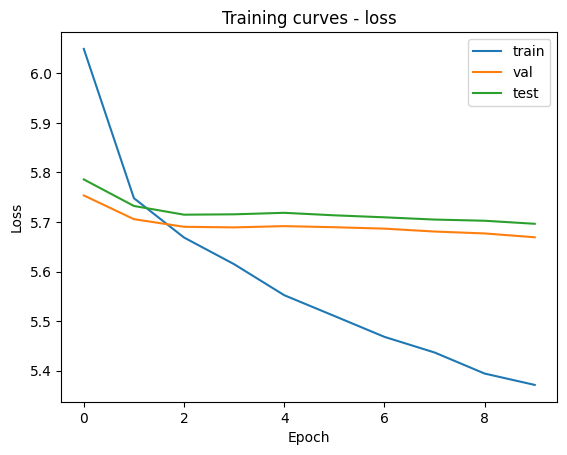

In [ ]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])